# Goal
+ estimate how many absolute newcomers there are (per 90 days) that make 4 quality edits
+ use the full sample size
+ use percentage that make 4 edits
+ user percentage of above that make 4 quality
  + in any namespace
  + in nontalk
  + in main-only
+ by lang

## populations active in pre-treatment
```
lang  experience_level_pre_treatment
ar    bin_0                               8547
de    bin_0                              14083
fa    bin_0                               6265
pl    bin_0                               3287
```
## estimates of  having 4 edits in that span
```
ar    bin_0                             1752/8547
de    bin_0                             2216/10000
fa    bin_0                             1634/6265
pl    bin_0                              893/3287

--->
ar 0.2049
de 0.2216
fa 0.2608
pl 0.2717
```

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [71]:
df = pd.read_csv('../outputs/thankee_power_analysis_data_for_sim_treatment_20180601_200_subsamples.csv')

In [3]:
bin_stats_active = pd.read_csv('../outputs/bin_stats_active_users.csv').rename({"users_with_at_least_days_experience":"abs_populations_90_pre_treatment"},axis=1)
bin_stats_min_four = pd.read_csv('../outputs/bin_stats_active_user_min_four_edits.csv').rename({"users_with_at_least_days_experience":"abs_populations_90_pre_treatment_min_four_edits"},axis=1)
bin_stats = pd.merge(bin_stats_active, bin_stats_min_four)

In [73]:
bin_stats['prop_having_4_edits_pre_treatment'] = bin_stats.apply(lambda row: row['abs_populations_90_pre_treatment_min_four_edits']/min(row['abs_populations_90_pre_treatment'], 10000), axis=1)

In [5]:
bin_stats

,experience_level_pre_treatment,lang,abs_populations_90_pre_treatment,abs_populations_90_pre_treatment_min_four_edits
0,bin_0,ar,8547,1752
1,bin_0,de,14083,2216
2,bin_0,fa,6265,1634
3,bin_0,pl,3287,893
4,bin_1460,ar,78626,438
5,bin_1460,de,277084,516
6,bin_1460,fa,50184,574
7,bin_1460,pl,61732,511
8,bin_180,ar,14809,348
9,bin_180,de,26677,464


In [8]:
bin_stats.groupby('lang').sum()

,abs_populations_90_pre_treatment,abs_populations_90_pre_treatment_min_four_edits
lang,,
ar,237407,4280
de,876166,5172
fa,159799,4869
pl,209754,4093


In [75]:
experience_groups = list(df['experience_level_pre_treatment'].value_counts().index.values)

In [76]:
experience_groups = sorted(experience_groups, key=lambda x: x.split('_')[1])

In [77]:
# experience_groups.append([e for e in experience_groups if e!= 'bin_0'])

In [78]:
experience_groups_names = [e if isinstance(e, str) else "non_newcomer" for e in experience_groups]

In [79]:
experience_groups_d = dict(zip(experience_groups_names, experience_groups))

In [80]:
def make_group_proportions(group_name, group, group_abs):
    group_qual = group.groupby('lang')['num_quality_pre_treatment',
       'num_quality_pre_treatment_non_talk',
       'num_quality_pre_treatment_main_only'].apply(lambda c: np.mean(c>=4)).rename({'num_quality_pre_treatment':'prop_qual_any',
       'num_quality_pre_treatment_non_talk':'prop_qual_non_talk',
       'num_quality_pre_treatment_main_only':'prop_qual_main_only'}, axis=1)
    group_stats = pd.merge(group_abs, group_qual, on='lang').set_index('lang')

    group_stats['abs_users_4_edits'] = group_stats['abs_populations_90_pre_treatment'] * group_stats['prop_having_4_edits_pre_treatment']
    group_stats['abs_users_4_edits_qual_any'] = group_stats['abs_users_4_edits'] * group_stats['prop_qual_any']
    group_stats['abs_users_4_edits_qual_non_talk'] = group_stats['abs_users_4_edits'] * group_stats['prop_qual_non_talk']
    group_stats['abs_users_4_edits_qual_main_only'] = group_stats['abs_users_4_edits'] * group_stats['prop_qual_main_only']

#     print(group_name)
#     group_stats.plot(kind='bar')
    return group_stats

In [81]:
prop_dfs = []
for name, group in experience_groups_d.items():
    subgroup = df[df['experience_level_pre_treatment'].apply(lambda g: g in group)]
    subgroup_abs = bin_stats[bin_stats['experience_level_pre_treatment'].apply(lambda g: g in group)]
    prop_df = make_group_proportions(name, subgroup, subgroup_abs)
    if name == 'non_newcomer':
#         print(subgroup)
        print(prop_df)
    prop_df['experience_level_pre_treatment']=name
    prop_dfs.append(prop_df.reset_index())

props = pd.concat(prop_dfs).set_index(['lang','experience_level_pre_treatment'])

#next steps:
visual representations:
-all experienced users (Same) 
-and experienced subgroups (same)

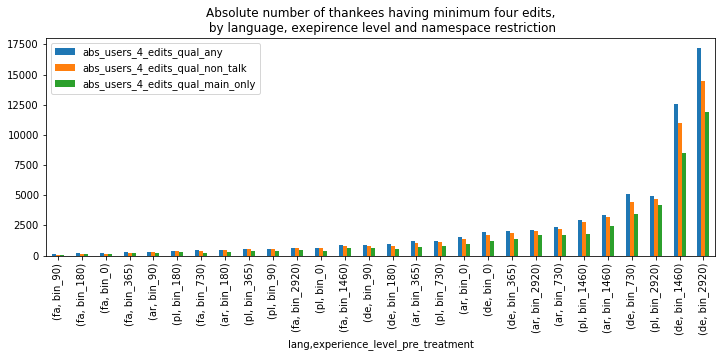

In [84]:
pplot = props[['abs_users_4_edits_qual_any','abs_users_4_edits_qual_non_talk','abs_users_4_edits_qual_main_only']]

pplots = pplot.sort_values('abs_users_4_edits_qual_non_talk')
pplots.plot(kind='bar', figsize=(12,4), title='Absolute number of thankees having minimum four edits,\n by language, exepirence level and namespace restriction')

In [88]:
pplots # estimated absolute thankees per 90, per language and experience group, with namespace restrictons

abs_users_4_edits_qual_any  \
lang experience_level_pre_treatment                               
fa   bin_90                                               90.18   
     bin_180                                             169.85   
     bin_0                                               236.93   
     bin_365                                             296.93   
ar   bin_90                                              332.10   
pl   bin_180                                             396.09   
fa   bin_730                                             484.87   
ar   bin_180                                             471.55   
pl   bin_365                                             534.82   
     bin_90                                              564.26   
fa   bin_2920                                            659.89   
pl   bin_0                                               642.96   
fa   bin_1460                                            864.17   
de   bin_90                                              844.47   
     bin_180                                             971.68   
ar   bin_365                                           1,201.44   
pl   bin_730                                           1,221.19   
ar   bin_0                                             1,537.38   
de   bin_0                                             1,927.09   
     bin_365                                           2,054.08   
ar   bin_2920                                          2,152.60   
     bin_730                                           2,326.26   
pl   bin_1460                                          2,933.69   
ar   bin_1460                                          3,357.72   
de   bin_730                                           5,114.35   
pl   bin_2920                                          4,965.76   
de   bin_1460                                         12,581.83   
     bin_2920                                         17,160.81   

                                     abs_users_4_edits_qual_non_talk  \
lang experience_level_pre_treatment                                    
fa   bin_90                                                    62.63   
     bin_180                                                  132.48   
     bin_0                                                    163.40   
     bin_365                                                  241.25   
ar   bin_90                                                   280.44   
pl   bin_180                                                  362.07   
fa   bin_730                                                  389.63   
ar   bin_180                                                  417.44   
pl   bin_365                                                  510.23   
     bin_90                                                   523.05   
fa   bin_2920                                                 588.34   
pl   bin_0                                                    611.70   
fa   bin_1460                                                 777.75   
de   bin_90                                                   809.28   
     bin_180                                                  829.33   
ar   bin_365                                                1,045.81   
pl   bin_730                                                1,145.73   
ar   bin_0                                                  1,357.80   
de   bin_0                                                  1,685.23   
     bin_365                                                1,843.40   
ar   bin_2920                                               2,023.44   
     bin_730                                                2,169.57   
pl   bin_1460                                               2,744.42   
ar   bin_1460                                               3,168.31   
de   bin_730                                                4,467.35   
pl   bin_2920                                               4,700.21   
de   bin_1

In [13]:
# df.groupby(['lang','experience_level_pre_treatment']).size()

In [14]:
df.groupby(['lang','experience_level_pre_treatment'])['num_quality_pre_treatment',
       'num_quality_pre_treatment_non_talk',
       'num_quality_pre_treatment_main_only'].apply(lambda c: c>=4).mean()

num_quality_pre_treatment             0.70
num_quality_pre_treatment_non_talk    0.63
num_quality_pre_treatment_main_only   0.46
dtype: float64

In [22]:
newcomer_abs = pd.DataFrame({'lang':['ar','de','fa','pl'],
              'abs_populations_90_pre_treatment':[8547, 14083, 6265, 3287],
             'prop_having_4_edits_pre_treatment':[0.2049, 0.2216, 0.2608, 0.2717]})

In [23]:
newcomer_abs

,lang,abs_populations_90_pre_treatment,prop_having_4_edits_pre_treatment
0,ar,8547,0.20
1,de,14083,0.22
2,fa,6265,0.26
3,pl,3287,0.27


In [24]:
newcomer_stats = pd.merge(newcomer_abs, newcomer_qual, on='lang').set_index('lang')

NameError: name 'newcomer_qual' is not defined

In [ ]:
newcomer_stats['abs_users_4_edits'] = newcomer_stats['abs_populations_90_pre_treatment'] * newcomer_stats['prop_having_4_edits_pre_treatment']
newcomer_stats['abs_users_4_edits_qual_any'] = newcomer_stats['abs_users_4_edits'] * newcomer_stats['prop_qual_any']
newcomer_stats['abs_users_4_edits_qual_non_talk'] = newcomer_stats['abs_users_4_edits'] * newcomer_stats['prop_qual_non_talk']
newcomer_stats['abs_users_4_edits_qual_main_only'] = newcomer_stats['abs_users_4_edits'] * newcomer_stats['prop_qual_main_only']


In [ ]:
newcomer_stats.T